# A(2021-11-11)
* GRU 사용
* Dataset 기간
 * train : 2016-01-01 01:00:00 - 2018-01-01 00:00:00
 * validation : 2018-01-01 01:00:00 - 2019-01-01 00:00:00	
 * test : '2019-01-01  01:00:00' - '2019-04-01 00:00:00' (총 2160개)
* 표준화 : MinMaxScaler 사용
* features : before_(1-3)y, (1-3)Y_shift_(1-24);1-3년 앞의 시점의 1-24시간 앞의 데이터, (1-3)Y_after_shift_(1-24);1~3년 뒤의 시점의 1-24시간 후의 데이터 총 3 + 3*24 + 3*24 = 147(columns)
 * train 할 때는 365일이 아닌(윤년 고려) 1년 단위로 끊었음. test 할때도 16년 2월 29일은 제외했음
* np.random.seed(1) 사용, loss='mean_squared_error', optimizer='adam', Dense(1)
* 나중에 해결할 것
 * lstm이 더 정확도가 좋은 듯함. 마지막은 그걸로 할 것.
 * 이렇게 1년 전 데이터부터 쓰면, 최근의 경향성을 알지 못함. 따라서 test에서 쓸 수 있는 가장 가까운 값인 3개월 전 데이터를 더 넣어주는 게 좋을 듯함
 * 날짜 말고 다른 데이터들을 넣어줘서 정확도를 올릴 것
 * 새로운 데이터 프레임을 만들지 말고, 공급량 value들을 list 안에 넣어서 효율적으로 만들자

# 필요한 라이브러리와 파일 가져오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
# 그래프 그리기
%matplotlib inline
import matplotlib.pyplot as plt
# 표준화 (MinMaxScaler)
from sklearn.preprocessing import MinMaxScaler
# 모델 생성
from keras.layers import GRU
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

total = pd.read_csv('/content/drive/Shareddrives/POLYDATA/data/원본 데이터/한국가스공사_시간별 공급량_20181231.csv', encoding = 'cp949')
submission = pd.read_csv('/content/drive/Shareddrives/POLYDATA/data/원본 데이터/sample_submission.csv')

# 원본 데이터 전처리

In [3]:
# 구분을 숫자로 바꿔주기(A=0, B=1, C=2, D=3, E=4, G=5, H=6)
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [4]:
total

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [5]:
# 시간을 연월일과 합쳐서 datetime으로 표현하기
total['시간'] = pd.to_timedelta(total['시간'], unit='h')
total['연월일'] = pd.to_datetime(total['연월일'])
total['datetime'] = total['연월일'] + total['시간']
total

,연월일,시간,구분,공급량,datetime
0,2013-01-01,0 days 01:00:00,0,2497.129,2013-01-01 01:00:00
1,2013-01-01,0 days 02:00:00,0,2363.265,2013-01-01 02:00:00
2,2013-01-01,0 days 03:00:00,0,2258.505,2013-01-01 03:00:00
3,2013-01-01,0 days 04:00:00,0,2243.969,2013-01-01 04:00:00
4,2013-01-01,0 days 05:00:00,0,2344.105,2013-01-01 05:00:00
...,...,...,...,...,...
368083,2018-12-31,0 days 20:00:00,6,681.033,2018-12-31 20:00:00
368084,2018-12-31,0 days 21:00:00,6,669.961,2018-12-31 21:00:00
368085,2018-12-31,0 days 22:00:00,6,657.941,2018-12-31 22:00:00
368086,2018-12-31,0 days 23:00:00,6,610.953,2018-12-31 23:00:00


In [6]:
total.drop(columns = ['연월일', '시간'], inplace=True)

In [7]:
# datetime을 datetime index로 쓰기
total.set_index('datetime', inplace=True)

In [8]:
total

,구분,공급량
datetime,,
2013-01-01 01:00:00,0,2497.129
2013-01-01 02:00:00,0,2363.265
2013-01-01 03:00:00,0,2258.505
2013-01-01 04:00:00,0,2243.969
2013-01-01 05:00:00,0,2344.105
...,...,...
2018-12-31 20:00:00,6,681.033
2018-12-31 21:00:00,6,669.961
2018-12-31 22:00:00,6,657.941


In [9]:
# 구분에 따라 데이터를 나눠서 df 라는 딕셔너리 안에 넣기
df = {}

for x in range(0,7):
  print(x)
  df['{0}'.format(x)] = total.loc[total['구분'] == x]

0
1
2
3
4
5
6


In [10]:
df['0']

,구분,공급량
datetime,,
2013-01-01 01:00:00,0,2497.129
2013-01-01 02:00:00,0,2363.265
2013-01-01 03:00:00,0,2258.505
2013-01-01 04:00:00,0,2243.969
2013-01-01 05:00:00,0,2344.105
...,...,...
2018-12-31 20:00:00,0,3040.868
2018-12-31 21:00:00,0,2973.577
2018-12-31 22:00:00,0,2840.272


# 표준화

In [11]:
# 편의를 위해 여기서 쓸 df['{}'] 를 df로 바꾸고 '구분' 지우기
df = df['0']
df = df.drop(columns = '구분')

In [12]:
scaler = MinMaxScaler()

df_sc = scaler.fit_transform(df)

In [13]:
df_sc

array([[0.20758986],
       [0.19592875],
       [0.18680293],
       ...,
       [0.23748162],
       [0.22459894],
       [0.21509985]])

In [14]:
df['공급량'] = df_sc

In [15]:
df

,공급량
datetime,
2013-01-01 01:00:00,0.207590
2013-01-01 02:00:00,0.195929
2013-01-01 03:00:00,0.186803
2013-01-01 04:00:00,0.185537
2013-01-01 05:00:00,0.194260
...,...
2018-12-31 20:00:00,0.254956
2018-12-31 21:00:00,0.249094
2018-12-31 22:00:00,0.237482


# 1,2,3년 전 데이터 가져오기

In [16]:
# 윤달도 존재하지만 하루 이틀은 큰 차이가 없기에 1년을 365일로 고정
Year =  pd.to_timedelta(365, unit='D')

# 나중에 편하게 dropna로 없애기 위해 null값 넣기
for x in range(1, 4):
  df['before_{}y'.format(x)] = np.NaN

# 첫 데이터인 2013-01-01 01:00:00로부터 3년이 이후인 시간을 
# 학습 데이터의 시작으로 설정할 것이다(그래야 3년 전 데이터 입력 가능)
for i in df.loc['2016-01-01 01:00:00':].index:
  for x in range(1, 4):
    df['before_{}y'.format(x)].loc[i] = df.loc[i - x * Year]['공급량']

In [17]:
df

,공급량,before_1y,before_2y,before_3y
datetime,,,,
2013-01-01 01:00:00,0.207590,NaN,NaN,NaN
2013-01-01 02:00:00,0.195929,NaN,NaN,NaN
2013-01-01 03:00:00,0.186803,NaN,NaN,NaN
2013-01-01 04:00:00,0.185537,NaN,NaN,NaN
2013-01-01 05:00:00,0.194260,NaN,NaN,NaN
...,...,...,...,...
2018-12-31 20:00:00,0.254956,0.184612,0.182891,0.163703
2018-12-31 21:00:00,0.249094,0.176035,0.167292,0.153331
2018-12-31 22:00:00,0.237482,0.169005,0.157846,0.146300


In [18]:
# null 값 제거 (3년 전 데이터가 없는 16년 전까지의 데이터 제거)
df_new = df.dropna()

In [19]:
df_new

,공급량,before_1y,before_2y,before_3y
datetime,,,,
2016-01-01 01:00:00,0.136195,0.184207,0.136169,0.207590
2016-01-01 02:00:00,0.126828,0.172873,0.126570,0.195929
2016-01-01 03:00:00,0.117962,0.160830,0.117077,0.186803
2016-01-01 04:00:00,0.116037,0.160758,0.117109,0.185537
2016-01-01 05:00:00,0.125550,0.169671,0.128369,0.194260
...,...,...,...,...
2018-12-31 20:00:00,0.254956,0.184612,0.182891,0.163703
2018-12-31 21:00:00,0.249094,0.176035,0.167292,0.153331
2018-12-31 22:00:00,0.237482,0.169005,0.157846,0.146300


# train과 validation dataset 나누기

In [20]:
split_date = pd.Timestamp('2018-01-01 00:00:00')

train = df_new.loc[:split_date]
val = df_new.loc[split_date:]

In [21]:
train

,공급량,before_1y,before_2y,before_3y
datetime,,,,
2016-01-01 01:00:00,0.136195,0.184207,0.136169,0.207590
2016-01-01 02:00:00,0.126828,0.172873,0.126570,0.195929
2016-01-01 03:00:00,0.117962,0.160830,0.117077,0.186803
2016-01-01 04:00:00,0.116037,0.160758,0.117109,0.185537
2016-01-01 05:00:00,0.125550,0.169671,0.128369,0.194260
...,...,...,...,...
2017-12-31 20:00:00,0.184612,0.182891,0.163703,0.229030
2017-12-31 21:00:00,0.176035,0.167292,0.153331,0.220726
2017-12-31 22:00:00,0.169005,0.157846,0.146300,0.214687


In [22]:
# 2018-01-01 00:00:00 이 train과 겹치므로 val에서 제거
val = val.iloc[1:]
val

,공급량,before_1y,before_2y,before_3y
datetime,,,,
2018-01-01 01:00:00,0.143814,0.132675,0.114695,0.173727
2018-01-01 02:00:00,0.136337,0.123204,0.098104,0.153121
2018-01-01 03:00:00,0.130388,0.114202,0.090197,0.146523
2018-01-01 04:00:00,0.129799,0.114011,0.092462,0.150834
2018-01-01 05:00:00,0.139153,0.122454,0.107258,0.171234
...,...,...,...,...
2018-12-31 20:00:00,0.254956,0.184612,0.182891,0.163703
2018-12-31 21:00:00,0.249094,0.176035,0.167292,0.153331
2018-12-31 22:00:00,0.237482,0.169005,0.157846,0.146300


# 앞 뒤 각각 24개씩의 공급량 데이터 가져오기

In [23]:
each_window_size = 24

# 과거값 'shift 1'~24'를 통해 현재값 'Scaled' 를 예측
for s in range(1, each_window_size +1):
  for x in range(1, 4):
    train['{0}Y_shift_{1}'.format(x, s)] = df_new['before_{}y'.format(x)].shift(s)
    val['{0}Y_shift_{1}'.format(x, s)] = df_new['before_{}y'.format(x)].shift(s)

    train['{0}Y_after_shift_{1}'.format(x, s)] = df_new['before_{}y'.format(x)].shift(-s)
    val['{0}Y_after_shift_{1}'.format(x, s)] = df_new['before_{}y'.format(x)].shift(-s)

train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,공급량,before_1y,before_2y,before_3y,1Y_shift_1,1Y_after_shift_1,2Y_shift_1,2Y_after_shift_1,3Y_shift_1,3Y_after_shift_1,1Y_shift_2,1Y_after_shift_2,2Y_shift_2,2Y_after_shift_2,3Y_shift_2,3Y_after_shift_2,1Y_shift_3,1Y_after_shift_3,2Y_shift_3,2Y_after_shift_3,3Y_shift_3,3Y_after_shift_3,1Y_shift_4,1Y_after_shift_4,2Y_shift_4,2Y_after_shift_4,3Y_shift_4,3Y_after_shift_4,1Y_shift_5,1Y_after_shift_5,2Y_shift_5,2Y_after_shift_5,3Y_shift_5,3Y_after_shift_5,1Y_shift_6,1Y_after_shift_6,2Y_shift_6,2Y_after_shift_6,3Y_shift_6,3Y_after_shift_6,...,2Y_shift_18,2Y_after_shift_18,3Y_shift_18,3Y_after_shift_18,1Y_shift_19,1Y_after_shift_19,2Y_shift_19,2Y_after_shift_19,3Y_shift_19,3Y_after_shift_19,1Y_shift_20,1Y_after_shift_20,2Y_shift_20,2Y_after_shift_20,3Y_shift_20,3Y_after_shift_20,1Y_shift_21,1Y_after_shift_21,2Y_shift_21,2Y_after_shift_21,3Y_shift_21,3Y_after_shift_21,1Y_shift_22,1Y_after_shift_22,2Y_shift_22,2Y_after_shift_22,3Y_shift_22,3Y_after_shift_22,1Y_shift_23,1Y_after_shift_23,2Y_shift_23,2Y_after_shift_23,3Y_shift_23,3Y_after_shift_23,1Y_shift_24,1Y_after_shift_24,2Y_shift_24,2Y_after_shift_24,3Y_shift_24,3Y_after_shift_24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,0.136195,0.184207,0.136169,0.207590,NaN,0.172873,NaN,0.126570,NaN,0.195929,NaN,0.160830,NaN,0.117077,NaN,0.186803,NaN,0.160758,NaN,0.117109,NaN,0.185537,NaN,0.169671,NaN,0.128369,NaN,0.194260,NaN,0.173689,NaN,0.129778,NaN,0.198341,NaN,0.180846,NaN,0.130512,NaN,0.197252,...,NaN,0.179704,NaN,0.241474,NaN,0.229030,NaN,0.174681,NaN,0.239462,NaN,0.220726,NaN,0.162937,NaN,0.229455,NaN,0.214687,NaN,0.161082,NaN,0.226259,NaN,0.208354,NaN,0.153829,NaN,0.215357,NaN,0.194935,NaN,0.144124,NaN,0.207357,NaN,0.173727,NaN,0.126533,NaN,0.194380
2016-01-01 02:00:00,0.126828,0.172873,0.126570,0.195929,0.184207,0.160830,0.136169,0.117077,0.207590,0.186803,NaN,0.160758,NaN,0.117109,NaN,0.185537,NaN,0.169671,NaN,0.128369,NaN,0.194260,NaN,0.173689,NaN,0.129778,NaN,0.198341,NaN,0.180846,NaN,0.130512,NaN,0.197252,NaN,0.195278,NaN,0.139073,NaN,0.209488,...,NaN,0.174681,NaN,0.239462,NaN,0.220726,NaN,0.162937,NaN,0.229455,NaN,0.214687,NaN,0.161082,NaN,0.226259,NaN,0.208354,NaN,0.153829,NaN,0.215357,NaN,0.194935,NaN,0.144124,NaN,0.207357,NaN,0.173727,NaN,0.126533,NaN,0.194380,NaN,0.153121,NaN,0.108491,NaN,0.180405
2016-01-01 03:00:00,0.117962,0.160830,0.117077,0.186803,0.172873,0.160758,0.126570,0.117109,0.195929,0.185537,0.184207,0.169671,0.136169,0.128369,0.207590,0.194260,NaN,0.173689,NaN,0.129778,NaN,0.198341,NaN,0.180846,NaN,0.130512,NaN,0.197252,NaN,0.195278,NaN,0.139073,NaN,0.209488,NaN,0.214592,NaN,0.154266,NaN,0.225827,...,NaN,0.162937,NaN,0.229455,NaN,0.214687,NaN,0.161082,NaN,0.226259,NaN,0.208354,NaN,0.153829,NaN,0.215357,NaN,0.194935,NaN,0.144124,NaN,0.207357,NaN,0.173727,NaN,0.126533,NaN,0.194380,NaN,0.153121,NaN,0.108491,NaN,0.180405,NaN,0.146523,NaN,0.101801,NaN,0.174961
2016-01-01 04:00:00,0.116037,0.160758,0.117109,0.185537,0.160830,0.169671,0.117077,0.128369,0.186803,0.194260,0.172873,0.173689,0.126570,0.129778,0.195929,0.198341,0.184207,0.180846,0.136169,0.130512,0.207590,0.197252,NaN,0.195278,NaN,0.139073,NaN,0.209488,NaN,0.214592,NaN,0.154266,NaN,0.225827,NaN,0.223190,NaN,0.164527,NaN,0.236766,...,NaN,0.161082,NaN,0.226259,NaN,0.208354,NaN,0.153829,NaN,0.215357,NaN,0.194935,NaN,0.144124,NaN,0.207357,NaN,0.173727,NaN,0.126533,NaN,0.194380,NaN,0.153121,NaN,0.108491,NaN,0.180405,NaN,0.146523,NaN,0.101801,NaN,0.174961,NaN,0.150834,NaN,0.111772,NaN,0.185094
2016-01-01 05:00:00,0.125550,0.169671,0.128369,0.194260,0.160758,0.173689,0.117109,0.129778,0.185537,0.198341,0.160830,0.180846,0.117077,0.130512,0.186803,0.197252,0.172873,0.195278,0.126570,0.139073,0.195929,0.209488,0.184207,0.214592,0.136169,0.154266,0.207590,0.225827,NaN,0.223190,NaN,0.164527,NaN,0.236766,NaN,0.217900,NaN,0.165099,NaN,0.242265,...,NaN,0.153829,NaN,0.215357,NaN,0.194935,NaN,0.144124,NaN,0.207357,NaN,0.173727,NaN,0.126533,NaN,0.194380,NaN

In [25]:
'''
null 값과 target(공급량) 없애주기
(3년 전의 24시간 전이 없는 16년 1월 1일과, 
df_new 내에 shift 할 값이 없는 17년 12월 31일이 제거됨)
17년 12월 31일은 제거될 필요가 없으므로, 
새 데이터프레임을 만들지 말고 기존의 공급량을 list에 넣어서 보존하는 방식을 쓰자
'''
X_train = train.dropna().drop('공급량', axis=1)
y_train = train.dropna()[['공급량']]

X_val = val.dropna().drop('공급량', axis=1)
y_val = val.dropna()[['공급량']]

In [26]:
len(train) - len(X_train)

24

In [27]:
X_train

,before_1y,before_2y,before_3y,1Y_shift_1,1Y_after_shift_1,2Y_shift_1,2Y_after_shift_1,3Y_shift_1,3Y_after_shift_1,1Y_shift_2,1Y_after_shift_2,2Y_shift_2,2Y_after_shift_2,3Y_shift_2,3Y_after_shift_2,1Y_shift_3,1Y_after_shift_3,2Y_shift_3,2Y_after_shift_3,3Y_shift_3,3Y_after_shift_3,1Y_shift_4,1Y_after_shift_4,2Y_shift_4,2Y_after_shift_4,3Y_shift_4,3Y_after_shift_4,1Y_shift_5,1Y_after_shift_5,2Y_shift_5,2Y_after_shift_5,3Y_shift_5,3Y_after_shift_5,1Y_shift_6,1Y_after_shift_6,2Y_shift_6,2Y_after_shift_6,3Y_shift_6,3Y_after_shift_6,1Y_shift_7,...,2Y_shift_18,2Y_after_shift_18,3Y_shift_18,3Y_after_shift_18,1Y_shift_19,1Y_after_shift_19,2Y_shift_19,2Y_after_shift_19,3Y_shift_19,3Y_after_shift_19,1Y_shift_20,1Y_after_shift_20,2Y_shift_20,2Y_after_shift_20,3Y_shift_20,3Y_after_shift_20,1Y_shift_21,1Y_after_shift_21,2Y_shift_21,2Y_after_shift_21,3Y_shift_21,3Y_after_shift_21,1Y_shift_22,1Y_after_shift_22,2Y_shift_22,2Y_after_shift_22,3Y_shift_22,3Y_after_shift_22,1Y_shift_23,1Y_after_shift_23,2Y_shift_23,2Y_after_shift_23,3Y_shift_23,3Y_after_shift_23,1Y_shift_24,1Y_after_shift_24,2Y_shift_24,2Y_after_shift_24,3Y_shift_24,3Y_after_shift_24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-02 01:00:00,0.173727,0.126533,0.194380,0.194935,0.153121,0.144124,0.108491,0.207357,0.180405,0.208354,0.146523,0.153829,0.101801,0.215357,0.174961,0.214687,0.150834,0.161082,0.111772,0.226259,0.185094,0.220726,0.171234,0.162937,0.132273,0.229455,0.205708,0.229030,0.190905,0.174681,0.142916,0.239462,0.230007,0.232845,0.213702,0.179704,0.174905,0.241474,0.255639,0.201061,...,0.130512,0.193183,0.197252,0.301075,0.173689,0.246365,0.129778,0.190533,0.198341,0.305252,0.169671,0.236275,0.128369,0.186774,0.194260,0.298356,0.160758,0.225212,0.117109,0.183525,0.185537,0.292000,0.160830,0.215536,0.117077,0.173610,0.186803,0.283981,0.172873,0.204295,0.126570,0.164192,0.195929,0.271573,0.184207,0.185983,0.136169,0.144193,0.207590,0.248630
2016-01-02 02:00:00,0.153121,0.108491,0.180405,0.173727,0.146523,0.126533,0.101801,0.194380,0.174961,0.194935,0.150834,0.144124,0.111772,0.207357,0.185094,0.208354,0.171234,0.153829,0.132273,0.215357,0.205708,0.214687,0.190905,0.161082,0.142916,0.226259,0.230007,0.220726,0.213702,0.162937,0.174905,0.229455,0.255639,0.229030,0.254170,0.174681,0.215884,0.239462,0.298785,0.232845,...,0.139073,0.190533,0.209488,0.305252,0.180846,0.236275,0.130512,0.186774,0.197252,0.298356,0.173689,0.225212,0.129778,0.183525,0.198341,0.292000,0.169671,0.215536,0.128369,0.173610,0.194260,0.283981,0.160758,0.204295,0.117109,0.164192,0.185537,0.271573,0.160830,0.185983,0.117077,0.144193,0.186803,0.248630,0.172873,0.163371,0.126570,0.124055,0.195929,0.226232
2016-01-02 03:00:00,0.146523,0.101801,0.174961,0.153121,0.150834,0.108491,0.111772,0.180405,0.185094,0.173727,0.171234,0.126533,0.132273,0.194380,0.205708,0.194935,0.190905,0.144124,0.142916,0.207357,0.230007,0.208354,0.213702,0.153829,0.174905,0.215357,0.255639,0.214687,0.254170,0.161082,0.215884,0.226259,0.298785,0.220726,0.272970,0.162937,0.229087,0.229455,0.311934,0.229030,...,0.154266,0.186774,0.225827,0.298356,0.195278,0.225212,0.139073,0.183525,0.209488,0.292000,0.180846,0.215536,0.130512,0.173610,0.197252,0.283981,0.173689,0.204295,0.129778,0.164192,0.198341,0.271573,0.169671,0.185983,0.128369,0.144193,0.194260,0.248630,0.160758,0.163371,0.117109,0.124055,0.185537,0.226232,0.160830,0.152956,0.117077,0.116797,0.186803,0.215568
2016-01-02 04:00:00,0.150834,0.111772,0.185094,0.146523,0.171234,0.101801,0.132273,0.174961,0.205708,0.153121,0.190905,0.108491,0.142916,0.180405,0.230007,0.173727,0.213702,0.126533,0.174905,0.194380,0.255639,0.194935,0.254170,0.144124,0.215884,0.207357,0.298785,0.208354,0.272970,0.153829,0.229087,0.215357,0.311934,0.214687,0.269809,0.161082,0.212921,0.226259,0.304871,0.220726,...,0.164527,0.183525,0.236766,0.292000,0.214592,0.215536,0.154266,0.173610,0.225827,0.283981,0.195278,0.204295,0.139073,0.164192,0.209488,0.271573,

In [28]:
y_train

,공급량
datetime,
2016-01-02 01:00:00,0.114695
2016-01-02 02:00:00,0.098104
2016-01-02 03:00:00,0.090197
2016-01-02 04:00:00,0.092462
2016-01-02 05:00:00,0.107258
...,...
2017-12-31 20:00:00,0.184612
2017-12-31 21:00:00,0.176035
2017-12-31 22:00:00,0.169005


# 모델에 넣어줄 3차원 형태로 바꾸기

In [29]:
X_train_v = X_train.values
X_val_v = X_val.values
y_train_v = y_train.values
y_val_v = y_val.values
print(X_train_v)
print(y_train_v)

                     before_1y  before_2y  ...  3Y_shift_24  3Y_after_shift_24
datetime                                   ...                                
2016-01-02 01:00:00   0.173727   0.126533  ...     0.207590           0.248630
2016-01-02 02:00:00   0.153121   0.108491  ...     0.195929           0.226232
2016-01-02 03:00:00   0.146523   0.101801  ...     0.186803           0.215568
2016-01-02 04:00:00   0.150834   0.111772  ...     0.185537           0.222690
2016-01-02 05:00:00   0.171234   0.132273  ...     0.194260           0.240402
...                        ...        ...  ...          ...                ...
2017-12-31 20:00:00   0.182891   0.163703  ...     0.227915           0.246365
2017-12-31 21:00:00   0.167292   0.153331  ...     0.224395           0.236275
2017-12-31 22:00:00   0.157846   0.146300  ...     0.216312           0.225212
2017-12-31 23:00:00   0.153891   0.139065  ...     0.208738           0.215536
2018-01-01 00:00:00   0.145865   0.129081  ...     0

In [30]:
# rnn은 3차원 데이터(size, timestep, feature)로 나타내주어야 함(보통은 2차원, 얘는 거기에+시간 개념)
# array.shape[0] : 전체 행의 갯수, .shape[1] : 전체 열의 갯수
window_size = 3 + 24*3 + 24*3
X_train_t = X_train_v.reshape(X_train.shape[0], window_size, 1)
X_val_t = X_val_v.reshape(X_val.shape[0], window_size, 1)

print('최종 DATA')
print(X_train_t.shape)
print(X_train_t)
print(y_train_v)

최종 DATA
(17520, 147, 1)
[[[0.17372712]
  [0.12653282]
  [0.19437956]
  ...
  [0.14419349]
  [0.20758986]
  [0.24862991]]

 [[0.15312069]
  [0.10849095]
  [0.18040545]
  ...
  [0.12405466]
  [0.19592875]
  [0.22623176]]

 [[0.1465225 ]
  [0.10180147]
  [0.17496063]
  ...
  [0.11679652]
  [0.18680293]
  [0.2155679 ]]

 ...

 [[0.15784632]
  [0.14630019]
  [0.21468703]
  ...
  [0.12986954]
  [0.21631218]
  [0.2252122 ]]

 [[0.15389076]
  [0.13906505]
  [0.20835366]
  ...
  [0.12511603]
  [0.20873834]
  [0.21553584]]

 [[0.14586464]
  [0.12908136]
  [0.19493498]
  ...
  [0.11863214]
  [0.20100004]
  [0.20429495]]]
[[0.11469539]
 [0.09810445]
 [0.0901975 ]
 ...
 [0.16900489]
 [0.1626636 ]
 [0.15533498]]


# 모델 학습

In [32]:
np.random.seed(1) # 난수 통일

K.clear_session()
model = Sequential() # Sequential Model
model.add(GRU(20, input_shape=(window_size, 1))) # (timestep, feature) ; size는 별로 안 중요해서 안 넣음
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam') # 실제 연속적인 값 예측 ; mean squared error

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20)                1380      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [33]:
!mkdir -p saved_model

early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
# patience는 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 것인지
# callback을 안 하면 마지막 모델을 써버림. 이전에 나온 가장 좋은 모델을 쓰기 위해 callback 해줘야 함

model.fit(X_train_t, y_train, epochs=150, batch_size=30, verbose=1, callbacks=[early_stop])
model.save('/content/drive/Shareddrives/POLYDATA/model/model_A_codeshare')
'''
from tensorflow import keras (모델을 부를 때는 이거 쓰기)
model = keras.models.load_model('/content/drive/Shareddrives/POLYDATA/model/model_A_codeshare')
'''

Epoch 1/150
584/584 [==============================] - 22s 34ms/step - loss: 7.9409e-04
Epoch 2/150
584/584 [==============================] - 20s 34ms/step - loss: 5.0744e-04
Epoch 3/150
584/584 [==============================] - 20s 34ms/step - loss: 5.0198e-04
Epoch 4/150
584/584 [==============================] - 20s 34ms/step - loss: 4.9563e-04
Epoch 5/150
584/584 [==============================] - 20s 34ms/step - loss: 4.9445e-04
Epoch 6/150
584/584 [==============================] - 20s 34ms/step - loss: 4.8525e-04
Epoch 7/150
584/584 [==============================] - 20s 34ms/step - loss: 4.8427e-04
Epoch 8/150
584/584 [==============================] - 20s 34ms/step - loss: 4.7776e-04
Epoch 9/150
584/584 [==============================] - 20s 34ms/step - loss: 4.7522e-04
Epoch 10/150
584/584 [==============================] - 20s 34ms/step - loss: 4.7335e-04
Epoch 11/150
584/584 [==============================] - 20s 34ms/step - loss: 4.7068e-04
Epoch 12/150
584/584 [========

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/model_A_codeshare/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/model_A_codeshare/assets


"\nfrom tensorflow import keras (모델을 부를 때는 이거 쓰기)\nmodel = keras.models.load_model('/content/drive/MyDrive/data/model_A_codeshare')\n"

# validation accuracy score(NMAE) 산출

In [35]:
# nmae 결과값 도출 함수 생성
def nmae(y, pred):
    return np.mean((np.abs(y-pred))/y)

In [36]:
# 학습한 모델로 예측치 산출
pred = model.predict(X_val_t)

In [37]:
pred

array([[0.1516832 ],
       [0.13632639],
       [0.12588204],
       ...,
       [0.17495695],
       [0.16931179],
       [0.16172457]], dtype=float32)

In [40]:
# 현재 pred는 표준화된 상태이므로, 다시 원래값으로 돌려줘야함
# scaler : 앞에서 썼던 MinMaxScaler
pred_in = scaler.inverse_transform(pred)
y_val_in = scaler.inverse_transform(y_val)


 NMAE score: 0.147935 



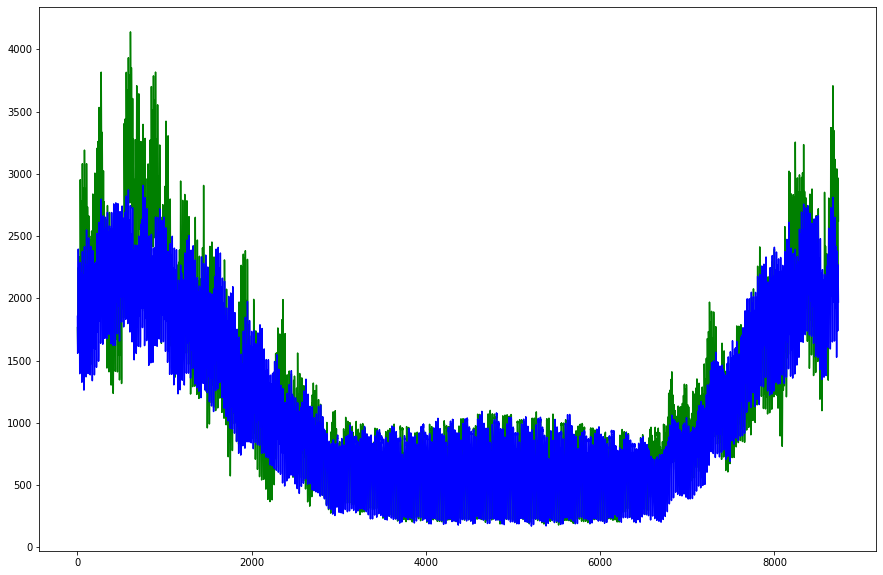

In [53]:
# 그래프의 크기 조절
plt.figure(figsize=(15,10))
# 그래프 그려서 비교
plt.plot(y_val_in, color='green')
plt.plot(pred_in, color='blue')
# NMAE score
print('\n NMAE score: {0:4f} \n'.format(nmae(y_val_in, pred_in)))

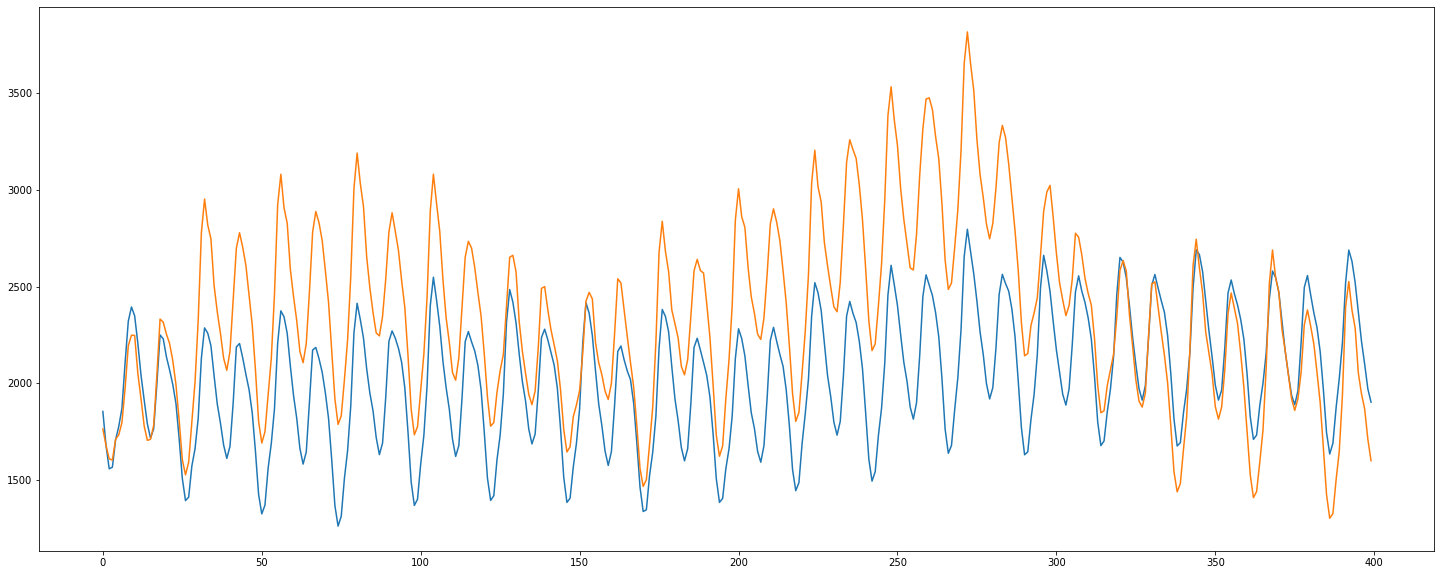

In [54]:
# 짧은 구간 보기
plt.figure(figsize=(25,10))
plt.plot(pred_in[:400])
plt.plot(y_val_in[:400])

# 결과 제출

In [55]:
'''
3년전의 데이터를 뽑기 위해
테스트 기간의 3년전의 윤달(2/29) 제거하기
(다음엔 그냥 1년 대신 365일을 쓰자)
'''
df_ex230 = df.drop(pd.date_range(start='2016-02-29 01:00:00',\
                                 end='2016-03-01 00:00:00', freq='h'))

In [56]:
# 데이터를 담을 나열해서 담을 데이터프레임 생성
test = pd.DataFrame()
# 데이터를 담을 리스트 생성
before_1y = []
before_2y = []
before_3y = []
# 테스트 기간인 '2019-01-01 01:00:00'-'2019-04-01 00:00:00'의 1,2,3년 전 데이터 추출
for i in df_ex230.loc['2015-12-31 01:00:00' :'2016-04-02 00:00:00'].index:
  # 1,2,3년 전 데이터를 하나씩 가져와서 리스트에 넣기
  before_1y.append(df_ex230.loc[i]['공급량'])
  before_2y.append(df_ex230.loc[i + 1*Year]['공급량'])
  before_3y.append(df_ex230.loc[i + 2*Year]['공급량'])

# 리스트 속에 담은 데이터를 데이터 프레임 속에 넣기
test['before_1y'] = before_1y
test['before_2y'] = before_2y
test['before_3y'] = before_3y

In [57]:
test

,before_1y,before_2y,before_3y
0,0.145414,0.177237,0.159760
1,0.123212,0.155128,0.140333
2,0.112080,0.144258,0.127840
3,0.111718,0.146039,0.128327
4,0.126598,0.164095,0.140265
...,...,...,...
2203,0.083744,0.116015,0.075149
2204,0.083112,0.111438,0.071448
2205,0.078217,0.105666,0.065300
2206,0.075492,0.099185,0.057398


In [58]:
# 앞에서 train, val 데이터 처리한 것 그대로 따라해서 동일하게 만들기
each_window_size = 24

# 과거값 'shift 1'~24'를 통해 현재값 'Scaled' 를 예측
for s in range(1, each_window_size +1):
  test['1Y_shift_{}'.format(s)] = test['before_1y'].shift(s)

  test['2Y_shift_{}'.format(s)] = test['before_2y'].shift(s)

  test['3Y_shift_{}'.format(s)] = test['before_3y'].shift(s)

  test['1Y_after_shift_{}'.format(s)] = test['before_1y'].shift(-s)

  test['2Y_after_shift_{}'.format(s)] = test['before_2y'].shift(-s)

  test['3Y_after_shift_{}'.format(s)] = test['before_3y'].shift(-s)

In [59]:
test

,before_1y,before_2y,before_3y,1Y_shift_1,2Y_shift_1,3Y_shift_1,1Y_after_shift_1,2Y_after_shift_1,3Y_after_shift_1,1Y_shift_2,2Y_shift_2,3Y_shift_2,1Y_after_shift_2,2Y_after_shift_2,3Y_after_shift_2,1Y_shift_3,2Y_shift_3,3Y_shift_3,1Y_after_shift_3,2Y_after_shift_3,3Y_after_shift_3,1Y_shift_4,2Y_shift_4,3Y_shift_4,1Y_after_shift_4,2Y_after_shift_4,3Y_after_shift_4,1Y_shift_5,2Y_shift_5,3Y_shift_5,1Y_after_shift_5,2Y_after_shift_5,3Y_after_shift_5,1Y_shift_6,2Y_shift_6,3Y_shift_6,1Y_after_shift_6,2Y_after_shift_6,3Y_after_shift_6,1Y_shift_7,...,3Y_shift_18,1Y_after_shift_18,2Y_after_shift_18,3Y_after_shift_18,1Y_shift_19,2Y_shift_19,3Y_shift_19,1Y_after_shift_19,2Y_after_shift_19,3Y_after_shift_19,1Y_shift_20,2Y_shift_20,3Y_shift_20,1Y_after_shift_20,2Y_after_shift_20,3Y_after_shift_20,1Y_shift_21,2Y_shift_21,3Y_shift_21,1Y_after_shift_21,2Y_after_shift_21,3Y_after_shift_21,1Y_shift_22,2Y_shift_22,3Y_shift_22,1Y_after_shift_22,2Y_after_shift_22,3Y_after_shift_22,1Y_shift_23,2Y_shift_23,3Y_shift_23,1Y_after_shift_23,2Y_after_shift_23,3Y_after_shift_23,1Y_shift_24,2Y_shift_24,3Y_shift_24,1Y_after_shift_24,2Y_after_shift_24,3Y_after_shift_24
0,0.145414,0.177237,0.159760,NaN,NaN,NaN,0.123212,0.155128,0.140333,NaN,NaN,NaN,0.112080,0.144258,0.127840,NaN,NaN,NaN,0.111718,0.146039,0.128327,NaN,NaN,NaN,0.126598,0.164095,0.140265,NaN,NaN,NaN,0.139850,0.181665,0.147406,NaN,NaN,NaN,0.156225,0.202514,0.153410,NaN,...,NaN,0.190708,0.209453,0.189319,NaN,NaN,NaN,0.189469,0.213565,0.187599,NaN,NaN,NaN,0.181187,0.202336,0.177717,NaN,NaN,NaN,0.173517,0.192023,0.170364,NaN,NaN,NaN,0.162301,0.183902,0.163315,NaN,NaN,NaN,0.150095,0.174273,0.155620,NaN,NaN,NaN,0.136195,0.157428,0.143633
1,0.123212,0.155128,0.140333,0.145414,0.177237,0.159760,0.112080,0.144258,0.127840,NaN,NaN,NaN,0.111718,0.146039,0.128327,NaN,NaN,NaN,0.126598,0.164095,0.140265,NaN,NaN,NaN,0.139850,0.181665,0.147406,NaN,NaN,NaN,0.156225,0.202514,0.153410,NaN,NaN,NaN,0.197628,0.243060,0.171037,NaN,...,NaN,0.189469,0.213565,0.187599,NaN,NaN,NaN,0.181187,0.202336,0.177717,NaN,NaN,NaN,0.173517,0.192023,0.170364,NaN,NaN,NaN,0.162301,0.183902,0.163315,NaN,NaN,NaN,0.150095,0.174273,0.155620,NaN,NaN,NaN,0.136195,0.157428,0.143633,NaN,NaN,NaN,0.126828,0.137782,0.130625
2,0.112080,0.144258,0.127840,0.123212,0.155128,0.140333,0.111718,0.146039,0.128327,0.145414,0.177237,0.159760,0.126598,0.164095,0.140265,NaN,NaN,NaN,0.139850,0.181665,0.147406,NaN,NaN,NaN,0.156225,0.202514,0.153410,NaN,NaN,NaN,0.197628,0.243060,0.171037,NaN,NaN,NaN,0.211166,0.257671,0.191541,NaN,...,NaN,0.181187,0.202336,0.177717,NaN,NaN,NaN,0.173517,0.192023,0.170364,NaN,NaN,NaN,0.162301,0.183902,0.163315,NaN,NaN,NaN,0.150095,0.174273,0.155620,NaN,NaN,NaN,0.136195,0.157428,0.143633,NaN,NaN,NaN,0.126828,0.137782,0.130625,NaN,NaN,NaN,0.117962,0.125752,0.119443
3,0.111718,0.146039,0.128327,0.112080,0.144258,0.127840,0.126598,0.164095,0.140265,0.123212,0.155128,0.140333,0.139850,0.181665,0.147406,0.145414,0.177237,0.159760,0.156225,0.202514,0.153410,NaN,NaN,NaN,0.197628,0.243060,0.171037,NaN,NaN,NaN,0.211166,0.257671,0.191541,NaN,NaN,NaN,0.202556,0.243194,0.200074,NaN,...,NaN,0.173517,0.192023,0.170364,NaN,NaN,NaN,0.162301,0.183902,0.163315,NaN,NaN,NaN,0.150095,0.174273,0.155620,NaN,NaN,NaN,0.136195,0.157428,0.143633,NaN,NaN,NaN,0.126828,0.137782,0.130625,NaN,NaN,NaN,0.117962,0.125752,0.119443,NaN,NaN,NaN,0.116037,0.126106,0.120166
4,0.126598,0.164095,0.140265,0.111718,0.146039,0.128327,0.139850,0.181665,0.147406,0.112080,0.144258,0.127840,0.156225,0.202514,0.153410,0.123212,0.155128,0.140333,0.197628,0.243060,0.171037,0.145414,0.177237,0.159760,0.211166,0.257671,0.191541,NaN,NaN,NaN,0.202556,0.243194,0.200074,NaN,NaN,NaN,0.197976,0.227311,0.201587,NaN,...,NaN,0.162301,0.183902,0.163315,NaN,NaN,NaN,0.150095,0.174273,0.155620,NaN,NaN,NaN,0.136195,0.157428,0.143633,NaN,NaN,NaN,0.126828,0.137782,0.130625,NaN,NaN,NaN,0.117962,0.125752,0.119443,NaN,NaN,NaN,0.116037,0.126106,0.120166,NaN,NaN,NaN,0.125550,0.139209,0.131682
...,...,...,..

In [60]:
# NULL 값 제거
test_new = test.dropna()

In [61]:
# 모델에 넣어줄 3차원 형식으로 만들어주기
test_new = test.dropna()

test_v = test_new.values

window_size = 3 + 24*3 + 24*3
test_t = test_v.reshape(test_v.shape[0], window_size, 1)

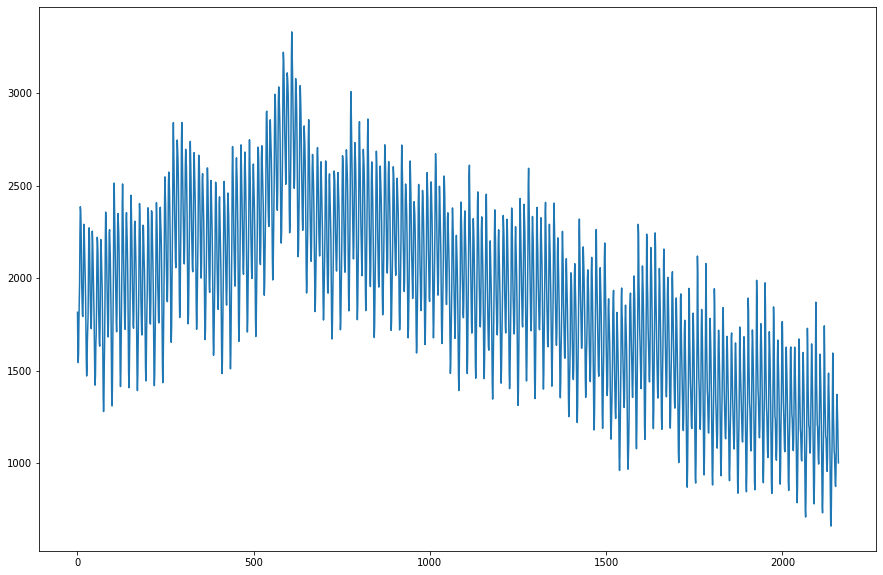

In [63]:
# 모델 속에 넣어서 예측치 산출
pred = model.predict(test_t)
# 표준화해준 걸 다시 원래 상태로 복구
pred_in = scaler.inverse_transform(pred)
# 그래프 그려서 값 확인
plt.figure(figsize=(15,10))
plt.plot(pred_in)

In [64]:
# 결과값 저장
sub_A = pd.DataFrame(data=pred_in)
sub_A.to_csv('/content/drive/Shareddrives/POLYDATA/결과/A 예측치/sub_A_codeshare.csv', encoding='cp949', index=False)